In [ ]:
# common
import pandas as pd
import numpy as np
import re
from bs4 import BeautifulSoup
import pyodbc
from collections import Counter
from datetime import datetime

# visualization imports
from IPython.display import display
import seaborn as sns
import pyLDAvis
import pyLDAvis.gensim  # don't skip this
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
plt.rcParams['image.cmap'] = 'gray'
import base64
import io
%matplotlib inline
sns.set()  # defines the style of the plots to be seaborn style

# languange processing imports
import nltk
from nltk import wordpunct_tokenize
from nltk.corpus import stopwords
from googletrans import Translator
from gensim.corpora import Dictionary

# preprocessing imports
from sklearn.preprocessing import LabelEncoder
from sklearn import metrics
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from scipy.spatial.distance import cdist

from gensim.corpora import MmCorpus
from gensim.test.utils import get_tmpfile

# model imports
import gensim
from gensim.models.ldamulticore import LdaMulticore
from gensim.models.word2vec import Word2Vec
from gensim.models import CoherenceModel
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.cluster import KMeans

# hyperparameter training imports
from sklearn.model_selection import GridSearchCV

# Remove unnecessary warnings
pd.options.mode.chained_assignment = None

### Modul import

In [4]:
# Common
import pandas as pd
import numpy as np

# Text processing
import re
from bs4 import BeautifulSoup
import nltk

# Visualization modules
import matplotlib.pyplot as plt

# Model modules
from sklearn.feature_extraction.text import TfidfVectorizer#, CountVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from scipy.spatial.distance import cdist
from sklearn.cluster import KMeans
from gensim.corpora import Dictionary
from gensim.corpora import MmCorpus
from gensim.test.utils import get_tmpfile
from gensim.test.utils import datapath
from gensim.models.ldamulticore import LdaMulticore

# Remove unnecessary warnings
pd.options.mode.chained_assignment = None


### Load Functions

In [1]:
def PlotValueCounts(df, column, topx=None):
    counts = df[column].value_counts()
    if topx:
        counts = counts[:topx,]
        title = 'Top {0} {1}'.format(topx, column)
    else:
        title = 'Rank of '.format(column)
    plt.figure(figsize=(10,8))
    sns.barplot(counts.values, counts.index, alpha=0.8)
    plt.title('{0}'.format(title))
    plt.ylabel(column)
    plt.xlabel('No of Occurences')
    plt.show()
    
def SummaryCounts(df):
    return df.value_counts()

def replace_specific_words(string):
    dictionary = {
    'vedr.': 'vedrørende',
    'vedr ': 'vedrørende ',
    'mdr.s': 'måneders',
    'mdr': 'måneder',
    'medl.': 'medlem',
    'o.s.v': 'og så videre',
    'm.m.': 'med mere.',
    'att ': 'til ',
    'att: ': 'til ',
    'att.: ': 'til ',
    'i.f.m': 'i forbindelse med',
    'ph.d.': 'philosophiaedoctor',
    ' d.': ' den',
    'ang.': 'angående',
    ' re ': ' svar ',
    ' re:': ' svar',
    '/': '/ ',
    'email': '',
    }
    
    for word, initial in dictionary.items():
        string = string.replace(word.lower(), initial)
    
    # Remove e-mail, Specify the number of replacements by changing the 4th argument
    string = re.sub(r'[\w\.-]+@[\w\.-]+','',string,0)
    
    # Remove words that are smaller than 2 letters
    string = re.sub(r'\b\w{1,2}\b', '',string)
    
    return string

def remove_standard_greetings(string):
    """ Removes
        Dear Name
        Dear Name Last
        Dear Name Middle Last
        and the newline right after
    """
    # Remove all start greeetings + name
    reg_rm_dear = r'\b(kære|hej|hejsa|hello|hi)\s?(\w[a-zA-Z\w.-]{2,}|\w[a-zA-Z\w.-]{2,}\s\w[a-zA-Z\w.-]{0,}|\w[a-zA-Z\w.-]{2,}\s\w[a-zA-Z\w.-]{0,}\s\w[a-zA-Z\w.-]{2,})?.?[\n]'
    string = re.sub(reg_rm_dear,'', str(string.lower()))
    
    # Remove all after curtisy + name
    reg_rm_regads = r'(\b(mvh|hilsen|venlig|med\svenlig\shilsen).*)'
    start_of_regards = re.findall(reg_rm_regads, string)
    
    if len(start_of_regards) > 0 and start_of_regards[0] is not None:
        start_of_regards = list(start_of_regards[0])[0]
        string = string[:string.find(start_of_regards)].strip()
    
    return string

def clean_text(text):
    "Parse HTML using BeautifulSoup and return the text"
    text = re.sub('</p><p>','</p>.\n<p>', str(text))
    text = BeautifulSoup(text, 'html.parser').get_text()
    text = remove_standard_greetings(text)
    words = text.lower().split()
    return ' '.join(words)

def clean_df(df_import):
    """
    0. Remove rows with empty columns
    1. Rename column names
    2. Pivot columns
    3. Remove rows containing NaN and None
    4. Convert HTML to text
    5. Reset index
    
    """
    df_clean = df_import.copy(deep=True)
    df_clean = df_clean[(pd.notnull(df_clean['BeskedTråd_Emne'])) & (pd.notnull(df_clean['Besked_Tekst']))]
    df_clean.rename(columns={
        'BeskedTråd_ID': 'BeskedTråd_ID',
        'BeskedTråd_OprettetFraBrev': 'OprettetFraBrev',
        'BeskedTråd_TotalAntalBeskeder':'TrådTotalAntalBeskeder',
        'BeskedTråd_Emne': 'Emne',
        'BeskedTråd_TeamAnsvarlig': 'TeamAnsvarlig',
        'Besked_ID': 'Besked_ID',
        'Besked_Tekst':'Henvendelse',
        'Besked_Retning': 'Retning',
        'Besked_SendtDato': 'SendtDato'}
                    , inplace=True)
    # Select which columns not to pivot. The rest are pivoted
    df_clean = df_clean.melt(id_vars=['BeskedTråd_ID','OprettetFraBrev','TrådTotalAntalBeskeder','TeamAnsvarlig','Besked_ID','Retning','SendtDato'])
    df_clean.rename(columns={'variable': 'BeskedKategori','value':'BeskedIndhold'}, inplace=True)
    df_clean['Org_BeskedIndhold'] = df_clean["BeskedIndhold"]
    df_clean["BeskedIndhold"]=df_clean.BeskedIndhold.apply(clean_text) # Convert from HTML
#     df_clean["BeskedIndhold"]=df_clean.BeskedIndhold.apply(remove_standard_greetings) # Remove greetings
    df_clean["BeskedIndhold"]=df_clean.BeskedIndhold.apply(replace_specific_words) # Replace specific words
    df_clean['CharCount_BeskedIndhold'] = df_clean['BeskedIndhold'].apply(len)
    df_clean['LessThan5000'] = df_clean['CharCount_BeskedIndhold'] < 5000
    
    df_clean = df_clean[df_clean['BeskedIndhold']!='nan'] # Remove Missing data
    df_clean = df_clean.reset_index(drop=True)
    return df_clean

In [49]:
def preprocess_string(text):
    "Takes a string, and prepares in a format to be taken by the LDAmodel for prediction"
    # df_data_prep
    text = clean_text(text) # "Parse HTML using BeautifulSoup and return the text"
#     text = remove_standard_greetings(text) # Remove start greeting
    text = replace_specific_words(text) # replace accronyms
    
    stopwords = nltk.corpus.stopwords.words('danish')
    dk_addition = [line.rstrip('\n') for line in open('data/danish_stopwords.txt')]
    dk_start_stop_message_words = ['kære','hilsen', 'mvh', 'venlig','tusind','tak']
    dk_addition.extend(dk_start_stop_message_words)
    
    customer_specific_words = ['akasse','aka','akademikernes','!','akadk']
    dk_addition.extend(customer_specific_words)
        
    stopwords.extend(dk_addition)
    stopwords = list(set(stopwords))
    
    
    # lda_get_good_tokens
    text = text.lower()
    text = nltk.word_tokenize(text)
    
    # get_good_tokens
    text = list(map(lambda t: re.sub(r'[^\wa-zA-Z0-9!?]+', '', t), text))
    text = list(filter(lambda token: not token.isdigit(), text))

    # remove_stopwords(df)
    text = list(filter(lambda t: t not in stopwords, text))
    text = list(filter(None, text))    
    
    # stem_words(df)
    lemm = nltk.stem.WordNetLemmatizer()
    text = list(map(lambda t: lemm.lemmatize(t), text))

    p_stemmer = nltk.stem.porter.PorterStemmer()
    text = list(map(lambda t: p_stemmer.stem(t), text))
    
    return text


def get_good_tokens(sentence):
    replaced_punctation = list(map(lambda token: re.sub(r'[^\wa-zA-Z0-9!?]+', '', token), sentence))
    removed_punctation = list(filter(lambda token: token, replaced_punctation))
    removed_punctation = list(filter(lambda token: not token.isdigit(), replaced_punctation))
    removed_empty = list(filter(None, removed_punctation))
    return removed_empty

def lda_get_good_tokens(df, col_name):
    df['text'] = df[col_name].str.lower()
    df['tokenized_text'] = list(map(nltk.word_tokenize, df[col_name]))
    df['tokenized_text'] = list(map(get_good_tokens, df.tokenized_text))
    

def df_data_prep(df, col_name):
    org = 'Org_'.format(col_name)
    df[org] = df[col_name]
    df[col_name]=df[col_name].apply(clean_text) # Convert from HTML
    df[col_name]=df[col_name].apply(replace_specific_words) # Replace specific words
    charcount = 'CharCount_{}'.format(col_name)
    df[charcount] = df[col_name].apply(len)
    df['LessThan5000'] = df[charcount] < 5000

# find and remove non-ascii words
# I stored our special word in a variable for later use
our_special_word = 'qwerty'

def remove_ascii_words(df, col_name):
    """ removes non-ascii characters from the 'texts' column in df.
    It returns the words containig non-ascii characers.
    """
    non_ascii_words = []
    for i in range(len(df)):
        for word in df.loc[i, col_name].split(' '):
            if any([ord(character) >= 128 for character in word]):
                non_ascii_words.append(word)
                df.loc[i, col_name] = df.loc[i, col_name].replace(word, our_special_word)
    return non_ascii_words

# non_ascii_words = remove_ascii_words(df, 'RequestContent')

# def remove_stopwords(df):
#     """ Removes stopwords based on a known set of stopwords
#     available in the nltk package. In addition, we include our
#     made up word in here.
#     """
#     # Luckily nltk already has a set of stopwords that we can remove from the texts.
#     stopwords = nltk.corpus.stopwords.words('danish')
#     dk_addition = [line.rstrip('\n') for line in open('data/danish_stopwords.txt')]
#     dk_start_stop_message_words = ['hilsen', 'mvh', 'venlig','tusind','tak']
#     dk_addition.extend(dk_start_stop_message_words)
#     stopwords.extend(dk_addition)
#     stopwords = list(set(stopwords))
#     # we'll add our own special word in here 'qwerty'
# #     stopwords.append(our_special_word)

#     df['stopwords_removed'] = list(map(lambda doc:
#                                        [word for word in doc if word not in stopwords],
#                                        df['tokenized_text']))

def remove_stopwords(df):
    """ Removes stopwords based on a known set of stopwords
    available in the nltk package. In addition, we include our
    made up word in here.
    """
    # Luckily nltk already has a set of stopwords that we can remove from the texts.
    stopwords = nltk.corpus.stopwords.words('danish')
    dk_addition = [line.rstrip('\n') for line in open('data/danish_stopwords.txt')]
    dk_start_stop_message_words = ['kære','hilsen', 'mvh', 'venlig','tusind','tak']
    dk_addition.extend(dk_start_stop_message_words)
    
    customer_specific_words = ['akasse','aka','akademikernes','?','!','akadk']
    dk_addition.extend(customer_specific_words)
        
    stopwords.extend(dk_addition)
    stopwords = list(set(stopwords))
    # we'll add our own special word in here 'qwerty'
    stopwords.append(our_special_word)

    df['stopwords_removed'] = list(map(lambda doc:
                                       [word for word in doc if word not in stopwords],
                                       df['tokenized_text']))
    
def stem_words(df):
    lemm = nltk.stem.WordNetLemmatizer()
    df['lemmatized_text'] = list(map(lambda sentence: list(map(lemm.lemmatize, sentence)), df.stopwords_removed))

    p_stemmer = nltk.stem.porter.PorterStemmer()
    df['stemmed_text'] = list(map(lambda sentence: list(map(p_stemmer.stem, sentence)), df.lemmatized_text))
    

def lda_preprocessing(df, col_name):
    """ All the preprocessing steps for LDA are combined in this function.
    All mutations are done on the dataframe itself. So this function returns
    nothing.
    """
    df_data_prep(df, col_name)
    lda_get_good_tokens(df, col_name)
    remove_stopwords(df)
    stem_words(df)

def dictionary_from_stem(df, no_above=None, no_below=None):
    """Create a dictionary for the model. 
    Since a computer can't reallly understand what a word means, we need to transform it 
    into some number the model will be able to work with. 
    We will use gensim.corpora.Dictionary for this.
    -- from gensim.corpora import Dictionary
    """
    dictionary = Dictionary(documents=df.stemmed_text.values)
    words_before_filter = len(dictionary.values())
    
    if no_above is not None and no_below is not None:
        dictionary.filter_extremes(no_above=no_above, no_below=no_below)
    elif no_above is not None:
        dictionary.filter_extremes(no_above=no_above)
    elif no_below is not None:
        dictionary.filter_extremes(no_below=no_below)
        
    dictionary.compactify()
    words_after_filter = len(dictionary.values())
    
    return dictionary, words_before_filter, words_after_filter

def document_to_bow(df):
    "Make a BoW for every Besked"
    df['bow'] = list(map(lambda doc: dictionary.doc2bow(doc), df.stemmed_text))

def document_to_lda_features(lda_model, document):
    """ Transforms a bag of words document to features.
    It returns the proportion of how much each topic was
    present in the document.
    """
    topic_importances = lda_model.get_document_topics(document, minimum_probability=0)
    topic_importances = np.array(topic_importances)
    return topic_importances[:,1]

def get_topic_top_words(lda_model, topic_id, nr_top_words=7):
    """ Returns the top words for topic_id from lda_model.
    """
    id_tuples = lda_model.get_topic_terms(topic_id, topn=nr_top_words)
    word_ids = np.array(id_tuples)[:,0]
    words = map(lambda id_: lda_model.id2word[id_], word_ids)
    return words

def get_topics_and_prob(lda_model, topic_id, nr_top_words=7):
    id_tuples = lda_model.print_topics(-1)
    topic_ids = np.array(id_tuples)[:,0]
    word_tuples = np.array(id_tuples)[:,1]
    top = dict(zip(topic_ids[:nr_top_words],word_tuples[:nr_top_words]))
#     topic_prop = map(lambda x: word_tuples, topic_ids) #map(lambda id_: lda_model.id2word[id_], topic_ids)
    return top

def get_topic_and_prob(lda_model, topic_id, nr_top_words=7):
    id_tuples = lda_model.print_topic(topic_id, topn=nr_top_words)
    return id_tuples

def get_lda_topics(model, num_topics, topn=10):
    word_dict = {};
    for i in sorted(np.argsort(RequestTopicDistribution)[-num_topics:]):
        words = model.show_topic(i, topn = topn);
        word_dict['Topic # ' + '{:02d}'.format(i)] = [i[0] for i in words];
    return pd.DataFrame(word_dict)

def preprocess(text):
    result = []
    for token in gensim.utils.simple_preprocess(text):
        if token not in gensim.parsing.preprocessing.STOPWORDS and len(token) > 3:
            result.append(lemmatize_stemming(token))
    return result

def PredictTopicFromString(text, LDAmodel, lda_topic_name_list):
    bow_vector = dictionary.doc2bow(preprocess_string(unseen_document))
    best_prediction = 0.0001
    prediction_index = None
    for index, score in sorted(LDAmodel[bow_vector], key=lambda tup: -1*tup[1]):
        if score > best_prediction:
            prediction_index = index
            best_prediction = score
    return best_prediction, lda_topic_name_list[prediction_index]#, LDAmodel_lang.print_topic(index, 5)
#     print("Score: {}\t Topic: {}".format(best_prediction, lda_topic_name_list[prediction_index])) #LDAmodel_lang.print_topic(index, 5)))

                   
def PredictTopicFromBOW(bow_vector, lda_model, lda_topic_name_list):
    "Input a string prepared bow-vector"
    best_prediction = 0
    prediction_index = None
    for index, score in sorted(lda_model[bow_vector], key=lambda tup: -1*tup[1]):
        if score > best_prediction:
            prediction_index = index
            best_prediction = score
#     pred = list(best_prediction, lda_topic_name_list[prediction_index])#, lda_model.print_topic(index, 5)
    pred = [best_prediction, prediction_index, lda_topic_name_list[prediction_index]]#, lda_model.print_topic(index, 5)
    return pred
#     print("Score: {}\t Topic: {}".format(best_prediction, lda_topic_name_list[prediction_index])) #LDAmodel_lang.print_topic(index, 5)))


def lda_prediction(df,lda_model, lda_topic_name_list):
    " Make the followint function into a function that returns the pred_label and pred_prob below"
#     for index, score in sorted(LDAmodel_lang[bow_vector], key=lambda tup: -1*tup[1]):
#         print("Score: {}\t Topic: {}".format(score, lda_model.print_topic(index, 5)))
    
#     df['bow'] = list(map(lambda doc: dictionary.doc2bow(doc), df.stemmed_text))
    df['prediction'] = df['bow'].apply(PredictTopicFromBOW,lda_model=lda_model, lda_topic_name_list=lda_topic_name_list)
    df[['pred_probability','pred_index','pred_label']] = pd.DataFrame(df.prediction.values.tolist(), index= df.index)
    df.drop(['prediction'], axis=1)
    
def ListToString(df):
    return ', '.join(df)

def remove_not_topwords(df_sample, df_population):
    """ Removes stopwords based on a known set of stopwords
    available in the nltk package. In addition, we include our
    made up word in here.
    Parameters:
    - no_below (int, optional) – Keep tokens which are contained in at least no_below documents.
    - no_above (float, optional) – Keep tokens which are contained in no more than no_above documents (fraction of total corpus size, not an absolute number).
    - keep_n (int, optional) – Keep only the first keep_n most frequent tokens.
    - keep_tokens (iterable of str) – Iterable of tokens that must stay in dictionary after filtering
    """
    dictionary = Dictionary(documents=df_population.stemmed_text.values) 
    
    # dictionary.filter_extremes(no_above=0.8, no_below=3, keep_n=500, keep_tokens=None)
    dictionary.filter_extremes(keep_n=500)

    dictionary.compactify()
    
    top_words = [v for v in dictionary.values()]

    top_words = list(set(top_words))

    df_sample['OnlyTopWords'] = list(map(lambda doc:
                                       [word for word in doc if word in top_words],
                                       df_sample['stemmed_text']))
    return top_words, dictionary

In [603]:
import pandas as pd

import re
from bs4 import BeautifulSoup
import nltk

def df_clean_sting(df, col_name):
    """ Cleans 'col_name' in a variaty of ways.
        Specificly designed with danish e-mails in mind."""

    def _clean_html(text):
        return BeautifulSoup(text, 'html.parser').get_text()
    
    replacements = {
        'vedr\.': 'vedrørende',
        'vedr': 'vedrørende',
        'mdr\.s': 'måneders',
        'mdr': 'måneder',
        'medl\.': 'medlem',
        '(o\.s\.v\.|osv\.)': 'og så videre',
        '(m\.m\.|mm\.)': 'med mere.',
        '(att|att\.)': 'til',
        'i\.f\.m\.': 'i forbindelse med',
        'ph\.d\.': 'philosophiaedoctor',
        '\sd\.': ' den',
        'ang\.': 'angående',
        '[\w\.-]+@[\w\.-]+': '', #remove e-mail
        }
        
    df[col_name]=df[col_name].str.replace('</p><p>','</p>.\n<p>').astype(str) # Insert newline in paragraphs
    df[col_name]=df[col_name].apply(_clean_html) # parse any HTML
    df[col_name]=df[col_name].str.lower() # convert text to lower
    df[col_name]=df[col_name].str.replace(r'^(\n*\s*|\n*\S*\s*)(\b|\b\w)(kære|hej|hejsa|hello|hi|dear)\s?(\w[a-zA-Z\w.-]{2,}|\w[a-zA-Z\w.-]{2,}\s\w[a-zA-Z\w.-]{0,}|\w[a-zA-Z\w.-]{2,}\s\w[a-zA-Z\w.-]{0,}\s\w[a-zA-Z\w.-]{2,})?.?[\n]?','') # remove greeting
    df[col_name]=df[col_name].str.split(r'(\b(med\svenlig\shilsen|de\sbedste\shilsner|mvh|hilsen|venlig|best\sregards|with\skind\sregards|kind\sregards|with\sregards|regards|sent\sfrom\smy\s).*)').str[0] # remove everything after polite ending
    df[col_name]=df[col_name].str.strip()
    df[col_name]=df[col_name].str.replace(r'[\w\.-]+@[\w\.-]+','') # remove e-mail
    df[col_name]=df[col_name].replace(regex=replacements) # replace anything found in the dictionary: replacements


def df_make_features_from_string(df, col_name):
    """ Add 
        - Count of Characters       -> int
        - LessThan5000              -> bool
        - Count of Question marks   -> int
        - 1Question                 -> bool
        - Count of Exclamation marks-> int
        """
    charcount = '{}_CharCount'.format(col_name)
    df[charcount] = df[col_name].str.len()
    lessthan = '{}_LessThan5000'.format(col_name)
    df[lessthan] = df[charcount] < 5000
    wordcount = '{}_WordCount'.format(col_name)
    df[wordcount] = df[col_name].str.split().str.len()
    questionmark = '{}_Questionmarks'.format(col_name)
    df[questionmark] = df[col_name].str.count('\?')
    onequestion = '{}_1Question'.format(col_name)
    df[onequestion] = df[questionmark] == 1
    exclamationmark = '{}_Exclamationmarks'.format(col_name)
    df[exclamationmark] = df[col_name].str.count('!')

def df_get_tokens(df, col_name):
    """ Create tokens of 'col_name """
    def _token_creator(sentence):
        replaced_punctation = list(map(lambda token: re.sub(r'[^\wa-zA-Z0-9!?]+', '', token), sentence))
        removed_punctation = list(filter(lambda token: token, replaced_punctation))
        removed_punctation = list(filter(lambda token: not token.isdigit(), replaced_punctation))
        removed_empty = list(filter(None, removed_punctation))
        return removed_empty

    df['tokenized_text'] = list(map(nltk.word_tokenize, df[col_name]))
    df['tokenized_text'] = list(map(_token_creator, df.tokenized_text))

def df_remove_stopwords(df, col_name):
    """ Removes stopwords based on a known set of stopwords
    available in the nltk package. In addition, we include our made up word in here.
    Input is a dataframe with a column, containing list of lists.
    """
    # danish stopword list
    dk_addition = [line.rstrip('\n') for line in open('data/danish_stopwords.txt')]
    dk_start_stop_message_words = ['kære','hilsen', 'mvh', 'venlig','tusind','tak']
    dk_addition.extend(dk_start_stop_message_words)
    
    # customer specific
    customer_specific_words = ['akasse','aka','akademikernes','?','!','akadk']
    dk_addition.extend(customer_specific_words)
    
    # nltk
    stopwords = nltk.corpus.stopwords.words('danish')
    stopwords.extend(dk_addition)
    stopwords = list(set(stopwords))
    # we'll add our own special word in here 'qwerty'
    stopwords.append(our_special_word)

    df['stopwords_removed'] = list(map(lambda doc: [word for word in doc if word not in stopwords], df[col_name]))

def df_stem_words(df, col_name):
    lemm = nltk.stem.WordNetLemmatizer()
    df['lemmatized_text'] = list(map(lambda sentence: list(map(lemm.lemmatize, sentence)), df[col_name]))

    p_stemmer = nltk.stem.porter.PorterStemmer()
    df['stemmed_text'] = list(map(lambda sentence: list(map(p_stemmer.stem, sentence)), df.lemmatized_text))

def df_lda_preprocessing(df, col_name, remove_stopwords=True):
    """ All the preprocessing steps for LDA are combined in this function.
    All mutations are done on the dataframe itself. So this function returns
    nothing.
    """
    df['text'] = df[col_name]
    df_clean_sting(df, 'text')
    df_make_features_from_string(df, 'text')

    df_get_tokens(df, 'text')
    if remove_stopwords:
        df_remove_stopwords(df, 'tokenized_text')
        df_stem_words(df, 'stopwords_removed')
    else:
        df_stem_words(df, 'tokenized_text')

def lda_preprocess_string(text):
    "Takes a string, and prepares in a format to be taken by the LDAmodel for prediction"

    def remove_standard_greetings(string):
        """ Removes
            Dear Name
            Dear Name Last
            Dear Name Middle Last
            and the newline right after
        """
        # Remove all start greeetings + name
        reg_rm_dear = r'^(\n*\s*|\n*\S*\s*)(\b|\b\w)(kære|hej|hejsa|hello|hi|dear)\s?(\w[a-zA-Z\w.-]{2,}|\w[a-zA-Z\w.-]{2,}\s\w[a-zA-Z\w.-]{0,}|\w[a-zA-Z\w.-]{2,}\s\w[a-zA-Z\w.-]{0,}\s\w[a-zA-Z\w.-]{2,})?.?[\n]?'
        string = re.sub(reg_rm_dear,'', str(string.lower()))
        
        # Remove all after curtisy + name
        reg_rm_regads = r'(\b(med\svenlig\shilsen|de\sbedste\shilsner|mvh|hilsen|venlig|best\sregards|with\skind\sregards|kind\sregards|with\sregards|regards|sent\sfrom\smy\s).*)'
        start_of_regards = re.findall(reg_rm_regads, string)
        
        if len(start_of_regards) > 0 and start_of_regards[0] is not None:
            start_of_regards = list(start_of_regards[0])[0]
            string = string[:string.find(start_of_regards)].strip()
        
        return string

    def clean_text(text):
        "Parse HTML using BeautifulSoup and return the text"
        text = re.sub('</p><p>','</p>.\n<p>', str(text))
        text = BeautifulSoup(text, 'html.parser').get_text()
        text = remove_standard_greetings(text)
        words = text.lower().split()
        return ' '.join(words)
    
    def replace_specific_words(string):
        dictionary = {
        'vedr.': 'vedrørende',
        'vedr ': 'vedrørende ',
        'mdr.s': 'måneders',
        'mdr': 'måneder',
        'medl.': 'medlem',
        'o.s.v': 'og så videre',
        'm.m.': 'med mere.',
        'att ': 'til ',
        'att: ': 'til ',
        'att.: ': 'til ',
        'i.f.m': 'i forbindelse med',
        'ph.d.': 'philosophiaedoctor',
        ' d.': ' den',
        'ang.': 'angående',
        ' re ': ' svar ',
        ' re:': ' svar',
        }
        
        for word, initial in dictionary.items():
            string = string.replace(word.lower(), initial)
        
        # Remove e-mail, Specify the number of replacements by changing the 4th argument
        string = re.sub(r'[\w\.-]+@[\w\.-]+','',string,0)
        
        # Remove words that are smaller than 2 letters
        string = re.sub(r'\b\w{1,2}\b', '',string)
        
        return string

    text = clean_text(text) # "Parse HTML using BeautifulSoup and return the text"
    text = replace_specific_words(text) # replace accronyms
    
    stopwords = nltk.corpus.stopwords.words('danish')
    dk_addition = [line.rstrip('\n') for line in open('data/danish_stopwords.txt')]
    dk_start_stop_message_words = ['kære','hilsen', 'mvh', 'venlig','tusind','tak']
    dk_addition.extend(dk_start_stop_message_words)
    
    customer_specific_words = ['akasse','aka','akademikernes','!','akadk']
    dk_addition.extend(customer_specific_words)
        
    stopwords.extend(dk_addition)
    stopwords = list(set(stopwords))
    
    
    # lda_get_good_tokens
    text = text.lower()
    text = nltk.word_tokenize(text)
    
    # get_good_tokens
    text = list(map(lambda t: re.sub(r'[^\wa-zA-Z0-9!?]+', '', t), text))
    text = list(filter(lambda token: not token.isdigit(), text))

    # remove_stopwords(df)
    text = list(filter(lambda t: t not in stopwords, text))
    text = list(filter(None, text))    
    
    # stem_words(df)
    lemm = nltk.stem.WordNetLemmatizer()
    text = list(map(lambda t: lemm.lemmatize(t), text))

    p_stemmer = nltk.stem.porter.PorterStemmer()
    text = list(map(lambda t: p_stemmer.stem(t), text))
    
    return text


def df_lda_features(lda_model, df, bow=None):
    def document_to_lda_features(lda_model, document):
        """ Transforms a bag of words document to features.
        It returns the proportion of how much each topic was
        present in the document.
        """
        topic_importances = lda_model.get_document_topics(document, minimum_probability=0)
        topic_importances = np.array(topic_importances)
        return topic_importances[:,1]

    if not bow:
        bow = df.bow

    df['lda_features'] = list(map(lambda doc: document_to_lda_features(LDAmodel_scope, doc), bow))

def get_lda_topics(model, num_topics, topn=10):
    word_dict = {}
    for i in sorted(np.argsort(RequestTopicDistribution)[-num_topics:]):
        words = model.show_topic(i, topn = topn)
        word_dict['Topic # ' + '{:02d}'.format(i)] = [i[0] for i in words]
    return pd.DataFrame(word_dict)

def lda_prediction(df,lda_model, lda_topic_name_list):
    " Make the followint function into a function that returns the pred_label and pred_prob below"
#     for index, score in sorted(LDAmodel_lang[bow_vector], key=lambda tup: -1*tup[1]):
#         print("Score: {}\t Topic: {}".format(score, lda_model.print_topic(index, 5)))
    
    df['bow'] = list(map(lambda doc: dictionary.doc2bow(doc), df.stemmed_text))
    df['prediction'] = df['bow'].apply(PredictTopicFromBOW,lda_model=lda_model, lda_topic_name_list=lda_topic_name_list)
    df[['pred_probability','pred_index','pred_label']] = pd.DataFrame(df.prediction.values.tolist(), index= df.index)
    df.drop(['prediction'], axis=1)

In [5]:
from lipht_lda import df_lda_preprocessing, lda_preprocess_string, df_lda_features, get_lda_topics, lda_prediction

# Import Data

In [407]:
# df_import = pd.read_pickle('data/AKA_rawdata.pkl')
# df_import = df_raw.copy(deep=True)

In [4]:
df_import = pd.read_pickle('data/AKA_rawdata_df_lda_preprocessed.pkl')

In [28]:
# Create dataset for method B
# Process 1st MemberMessage, then
# Concatenate with Subject
df_B = df_import.copy(deep=True)
df_B.head()

,ThreadID,ThreadCreatedFromLetter,ThreadTotalMessageCount,ThreadStatus,ThreadSubject,ThreadResponsibleDepartment,ThreadResponsibleDepartmentTeam,ThreadHasInteraction,ThreadInitiatedBy,ThreadMessageRank,...,text_Exclamationmarks,tokenized_text,stopwords_removed,lemmatized_text,stemmed_text,bow,prediction,pred_probability,pred_index,pred_label
0,3F206D77-DFB5-E811-82B4-0050569118B0,0,1,Fuldført,Du er tilmeldt et arrangement,Jobmatch,Logistik,0,AKA,1,...,0,"[din, booking, er, på, plads, vi, bekræfter, a...","[booking, plads, bekræfter, tilmeldt, studieku...","[booking, plads, bekræfter, tilmeldt, studieku...","[book, plad, bekræfter, tilmeldt, studiekursu,...","[(44, 1), (48, 1), (107, 1), (132, 1), (146, 1...","[0.96564174, 0, Danish]",0.965642,0,Danish
1,A4B4F902-E4B5-E811-82B4-0050569118B0,0,1,Fuldført,Du er tilmeldt et arrangement,Jobmatch,Logistik,0,AKA,1,...,0,"[din, booking, er, på, plads, vi, bekræfter, a...","[booking, plads, bekræfter, tilmeldt, talent, ...","[booking, plads, bekræfter, tilmeldt, talent, ...","[book, plad, bekræfter, tilmeldt, talent, tilr...","[(35, 1), (44, 1), (48, 1), (132, 1), (146, 1)...","[0.8443553, 0, Danish]",0.844355,0,Danish
2,C7AAAE22-E4B5-E811-82B4-0050569118B0,0,1,Fuldført,Du er tilmeldt et arrangement,Jobmatch,Logistik,0,AKA,1,...,0,"[din, booking, er, på, plads, vi, bekræfter, a...","[booking, plads, bekræfter, tilmeldt, talent, ...","[booking, plads, bekræfter, tilmeldt, talent, ...","[book, plad, bekræfter, tilmeldt, talent, tilr...","[(44, 1), (48, 1), (132, 1), (146, 1), (153, 1...","[0.866124, 0, Danish]",0.866124,0,Danish
3,447AC33F-E6B5-E811-82B4-0050569118B0,0,1,Fuldført,Du er nu afmeldt ventelisten til LinkedIn,Jobmatch,Logistik,0,AKA,1,...,0,"[du, er, nu, afmeldt, ventelisten, til, linked...","[afmeldt, ventelisten, linkedin, blevet, tilbu...","[afmeldt, ventelisten, linkedin, blevet, tilbu...","[afmeldt, ventelisten, linkedin, blevet, tilbu...","[(8, 1), (13, 1), (37, 1), (44, 1), (132, 1), ...","[0.9660929, 0, Danish]",0.966093,0,Danish
4,80A4A5A3-EAB5-E811-82B4-0050569118B0,0,1,Fuldført,Du er nu på venteliste til Mindfulness,Jobmatch,Logistik,0,AKA,1,...,0,"[salvador, rodriguez, du, er, nu, på, ventelis...","[salvador, rodriguez, ventelisten, mindfulness...","[salvador, rodriguez, ventelisten, mindfulness...","[salvador, rodriguez, ventelisten, mind, septe...","[(11, 1), (44, 1), (63, 1), (132, 1), (151, 1)...","[0.9462947, 0, Danish]",0.946295,0,Danish


In [6]:
df_B.shape

(1101095, 32)

In [29]:
%%time
# df_B = df_B[(df_B['ThreadStatus']=='Fuldført') & (df_B['ThreadMessageDirection']=='Indgående') & (df_B['ThreadMessageIsFirstMemberMessage']==1) & (df_B['ThreadTotalMessageCount']>1) & (df_B['ThreadHasInteraction']>=1) & (df_B['ThreadResponsibleDepartmentTeam']=='Udbetalingsteam') & (df_B['pred_label']=='Danish')]
df_B = df_B[(df_B['ThreadStatus']=='Fuldført') & (df_B['ThreadMessageDirection']=='Indgående') & (df_B['ThreadMessageIsFirstMemberMessage']==1) & (df_B['ThreadResponsibleDepartmentTeam'].str.contains('Udbetalingsteam')==True) & (df_B['pred_label']=='Danish')]
print(df_B.shape)

(87707, 32)
Wall time: 1.31 s


In [30]:
df_B.ThreadResponsibleDepartmentTeam.unique()

array(['Udbetalingsteam 1 - CPR 01 til 10',
       'Udbetalingsteam 2 - CPR 11 til 20',
       'Udbetalingsteam 3 - CPR 21 til 31', 'Udbetalingsteam'],
      dtype=object)

In [537]:
%%time
df_lda_preprocessing(df_B,'ThreadMessageText')

Wall time: 5min 6s


In [31]:
df_B.isnull().sum()

ThreadID                              0
ThreadCreatedFromLetter               0
ThreadTotalMessageCount               0
ThreadStatus                          0
ThreadSubject                        12
ThreadResponsibleDepartment           0
ThreadResponsibleDepartmentTeam       0
ThreadHasInteraction                  0
ThreadInitiatedBy                     0
ThreadMessageRank                     0
ThreadMessageIsFirstMemberMessage     0
ThreadMessageIsFirstAKAMessage        0
ThreadMessageID                       0
ThreadMessageDirection                0
ThreadMessageDateCreated              0
ThreadMessageText                     0
text                                  0
text_CharCount                        0
text_LessThan5000                     0
text_WordCount                        0
text_Questionmarks                    0
text_1Question                        0
text_Exclamationmarks                 0
tokenized_text                        0
stopwords_removed                     0


In [9]:
print(df_B.shape)

(142533, 32)


In [33]:
df_B.to_pickle('data/df_B.pkl')

## Analyze Requests
Messages are either
- Incoming (from members) or
- Outgoing (from aka)
All messeages have
- subject_field and
- message_field

In the following we will analyze the different splits of data, with regards to the above:
- Incoming_subject
- Incoming_message
- Outgoing_subject
- Outgoing_message

### Request Analysis: subject_member

#### Setup Analysis Parameters

In [6]:
dataset = 'df_B'
sample_size= 10000
no_words= 1000 
no_below= 15 # filter out tokens that appear in less than 15 documents
random_state=1
research_scope = 'Udbetaling'
num_topics = 20

#### Load the data

In [7]:
%%time
# Load the data, and print rows, columns
df_scope = pd.read_pickle('data/{}.pkl'.format(dataset))

Wall time: 7.63 s


In [8]:
df_scope.shape

(87707, 32)

In [52]:
data_scope_name = research_scope +'_topics-'+ str(num_topics) +'_Sample-'+str(sample_size) +'_WordCount-'+str(no_words) +'_RandomState-'+str(random_state)+'_dataset-'+ dataset
print(data_scope_name)

Udbetaling_topics-20_Sample-10000_WordCount-1000_RandomState-1_dataset-df_B


### Vectorize words

#### Create dictionary and top words

##### Parameters:	
- **no_below** (int, optional) – Keep tokens which are contained in at least no_below documents.
- **no_above** (float, optional) – Keep tokens which are contained in no more than no_above documents (fraction of total corpus size, not an absolute number).
- **keep_n** (int, optional) – Keep only the first keep_n most frequent tokens.
- **keep_tokens** (iterable of str) – Iterable of tokens that must stay in dictionary after filtering.

In [10]:
%%time
# Create dictionary with words from df_scope (the total dataset)
dictionary = Dictionary(documents=df_scope.stemmed_text.values)
print("Found {} words.".format(len(dictionary.values())))

Found 76833 words.
Wall time: 2.96 s


In [11]:
%%time
# dictionary.filter_extremes(no_above=0.8, no_below=3)
dictionary.filter_extremes(no_below=no_below, keep_n=no_words)

dictionary.compactify()  # Reindexes the remaining words after filtering
print("Left with {} words.".format(len(dictionary.values())))

Left with 1000 words.
Wall time: 144 ms


In [12]:
def document_to_bow(df):
    "Make a BoW for every Besked"
    df['bow'] = list(map(lambda doc: dictionary.doc2bow(doc), df.stemmed_text))

In [13]:
%%time
#Make a BoW for every Besked
document_to_bow(df_scope)

Wall time: 1.88 s


In [14]:
scope_lda_sample = df_scope.sample(sample_size)
scope_lda_sample.shape

(10000, 32)

In [15]:
scope_lda_sample.columns.values

array(['ThreadID', 'ThreadCreatedFromLetter', 'ThreadTotalMessageCount',
       'ThreadStatus', 'ThreadSubject', 'ThreadResponsibleDepartment',
       'ThreadResponsibleDepartmentTeam', 'ThreadHasInteraction',
       'ThreadInitiatedBy', 'ThreadMessageRank',
       'ThreadMessageIsFirstMemberMessage',
       'ThreadMessageIsFirstAKAMessage', 'ThreadMessageID',
       'ThreadMessageDirection', 'ThreadMessageDateCreated',
       'ThreadMessageText', 'text', 'text_CharCount', 'text_LessThan5000',
       'text_WordCount', 'text_Questionmarks', 'text_1Question',
       'text_Exclamationmarks', 'tokenized_text', 'stopwords_removed',
       'lemmatized_text', 'stemmed_text', 'bow', 'prediction',
       'pred_probability', 'pred_index', 'pred_label'], dtype=object)

In [16]:
scope_lda_sample[['ThreadID','ThreadMessageID','ThreadSubject','ThreadMessageText','text','tokenized_text','stopwords_removed','lemmatized_text','stemmed_text']].head()

,ThreadID,ThreadMessageID,ThreadSubject,ThreadMessageText,text,tokenized_text,stopwords_removed,lemmatized_text,stemmed_text
1067097,D8404B4C-5E8D-E711-BE8E-005056AD2D14,E2404B4C-5E8D-E711-BE8E-005056AD2D14,Vi mangler oplysninger til din ansøgning om da...,\nHej Steen\nTak for dit brev.\nJeg har forsøg...,tak for dit brev.\njeg har forsøgt at ringe ti...,"[tak, for, dit, brev, jeg, har, forsøgt, at, r...","[brev, forsøgt, ringe, par, gange, direkte, nu...","[brev, forsøgt, ringe, par, gange, direkte, nu...","[brev, forsøgt, ring, par, gang, direkt, numme..."
232460,C85EF8D9-D672-E811-82F9-005056AD2D14,D25EF8D9-D672-E811-82F9-005056AD2D14,Spørgsmål,"\nHej med Jer,\n \nPga en organisationsændring...","jer,\n \npga en organisationsændring på mit nu...","[jer, pga, en, organisationsændring, på, mit, ...","[pga, organisationsændring, nuværende, arbejde...","[pga, organisationsændring, nuværende, arbejde...","[pga, organisationsændr, nuværend, arbejd, sti..."
809957,0DEB3A15-41D0-E611-B361-005056AD2D14,14EB3A15-41D0-E611-B361-005056AD2D14,Tro- og loveerklæring i forbindelse med kollek...,\nKære Akademikernes\nVedhæftet sendes Tro- og...,vedhæftet sendes tro- og loveerklæring i forbi...,"[vedhæftet, sendes, tro, og, loveerklæring, i,...","[vedhæftet, sendes, tro, loveerklæring, forbin...","[vedhæftet, sendes, tro, loveerklæring, forbin...","[vedhæftet, send, tro, loveerklær, forbindels,..."
661277,097E59F5-E842-E611-B263-005056AD2D14,107E59F5-E842-E611-B263-005056AD2D14,[id:e5R2dzvPEeayYwBQVq0tFA],\n\nHej\nJeg søger om feriedagpenge for uge 30...,"søger om feriedagpenge for uge 30, idet jeg fr...","[søger, om, feriedagpenge, for, uge, idet, jeg...","[søger, feriedagpenge, uge, idet, tidspunkt, o...","[søger, feriedagpenge, uge, idet, tidspunkt, o...","[søger, feriedagpeng, uge, idet, tidspunkt, op..."
572250,20CCBAC5-C61D-E711-AC9F-005056AD2D14,2BCCBAC5-C61D-E711-AC9F-005056AD2D14,Du kan søge om feriedagpenge,\njeg har et spørgsmål ang. feriedagpenge. \n ...,jeg har et spørgsmål angående feriedagpenge. \...,"[jeg, har, et, spørgsmål, angående, feriedagpe...","[spørgsmål, angående, feriedagpenge, vœre, sel...","[spørgsmål, angående, feriedagpenge, vœre, sel...","[spørgsmål, angåend, feriedagpeng, vœre, selvs..."


### Find optimal number of topics for LDA
#### K-means Elbow method

#### Create Sample of Scope

#### Create Topwords
Create a list of topwords from the entire dataframe

#### Tf-idf and document similarity

I define term frequency-inverse document frequency (tf-idf) vectorizer parameters and then convert the clean_content list into a tf-idf matrix.

To get a Tf-idf matrix, first count word occurrences by request. This is transformed into a request-term matrix (dtm). This is also just called a term frequency matrix.

Then apply the term frequency-inverse document frequency weighting: words that occur frequently within a request but not frequently within the corpus receive a higher weighting as these words are assumed to contain more meaning in relation to the request.

A couple things to note about the parameters I define below:

max_df: this is the maximum frequency within the request a given feature can have to be used in the tfi-idf matrix. If the term is in greater than 80% of the request it probably cares little meanining - rule of thumb (verify this)

min_idf: this could be an integer (e.g. 5) and the term would have to be in at least 5 of the request to be considered. Here I pass 0.2; the term must be in at least 20% of the request. 

TEST THIS
I found that if I allowed a lower min_df I ended up basing clustering on names--for example "Michael" or "Tom" are names found in several of the movies and the synopses use these names frequently, but the names carry no real meaning.

ngram_range: this just means I'll look at unigrams, bigrams and trigrams. See n-grams

In [48]:
%%time
top_words = [v for v in dictionary.values()]
top_words = list(set(top_words))
df_scope['OnlyTopWords'] = list(map(lambda doc: [word for word in doc if word in top_words], df_scope['stemmed_text']))

Wall time: 20.8 s


In [ ]:
print("No of top words: {} ".format(len(top_words)))

In [353]:
# %%time
top_words, _ = remove_not_topwords(scope_lda_sample, df_scope)

In [354]:
# # Create dictionary with words from df_scope (the total dataset) or scope_lda_sample (the sample size)
# dictionary = Dictionary(documents=df_scope.stemmed_text.values)
# #Make a BoW for every Besked
# document_to_bow(df_scope)

In [355]:
# LDA preprocessing
print("Found {} words.".format(len(dictionary.values())))

Found 500 words.


In [356]:
%%time
scope_lda_sample['clean_content'] = scope_lda_sample['OnlyTopWords'].apply(ListToString)

Wall time: 9 ms


In [357]:
%%time
tfidf_wordvector = TfidfVectorizer(
                analyzer='word', 
                max_df=0.8, 
                min_df=5, 
#                 stop_words=stopwords.words('danish'),
#                 ngram_range=(1,3)
                ) 

#fit the tfidf_wordvector to clean_content
tfidf_wordvector_maxtrix = tfidf_wordvector.fit_transform(scope_lda_sample.clean_content)
print(tfidf_wordvector_maxtrix.shape)

(5000, 500)
Wall time: 117 ms


dist is defined as 1 - the cosine similarity of each request. Cosine similarity is measured against the tf-idf matrix and can be used to generate a measure of similarity between each request and the other request in the corpus (each clean_content among the total clean_content). Subtracting it from 1 provides cosine distance which I will use for plotting on a euclidean (2-dimensional) plane.

Note that with dist it is possible to evaluate the similarity of any two or more clean_content.

In [358]:
tfidf_wordvector_2d = tfidf_wordvector_maxtrix.todense()

In [359]:
top_range = 151
increments = 5

In [360]:
%%time
distortions = []
K = range(1,top_range,increments)
for k in K:
    kmeanModel = KMeans(n_clusters=k, n_jobs=-1, random_state=0).fit(tfidf_wordvector_2d)
    kmeanModel.fit(tfidf_wordvector_2d)
    distortions.append(sum(np.min(cdist(tfidf_wordvector_2d, kmeanModel.cluster_centers_, 'euclidean'), axis=1)) / tfidf_wordvector_2d.shape[0])

Wall time: 15min 19s


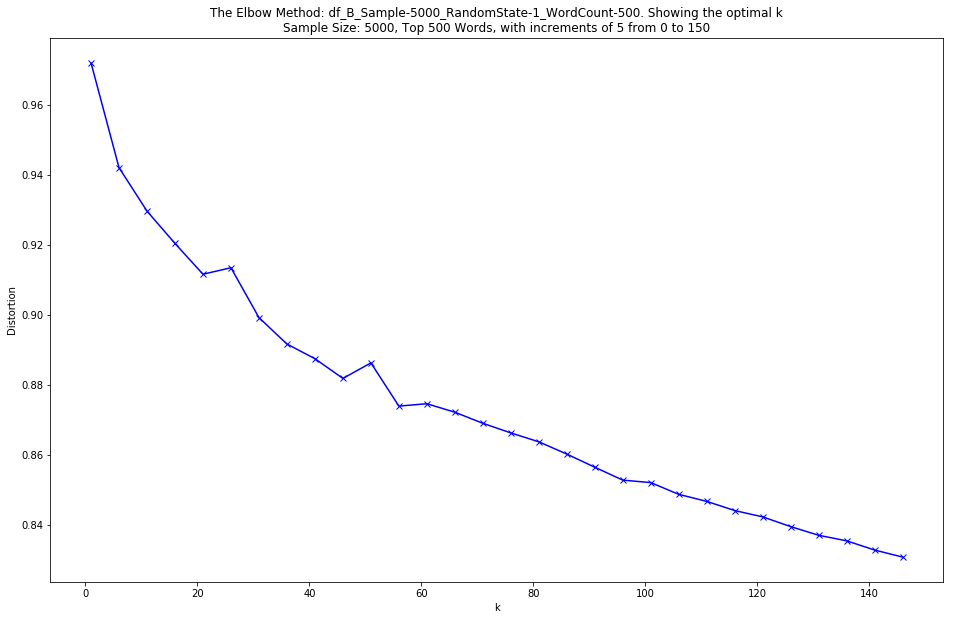

In [361]:
# Plot the elbow
plt.figure(figsize=(16, 10))
plt.plot(K, distortions, 'bx-')
plt.xlabel('k')
plt.ylabel('Distortion')
plt.title('The Elbow Method: {4}. Showing the optimal k\nSample Size: {0}, Top {1} Words, with increments of {2} from 0 to {3}'.format(sample_size, len(top_words), increments, top_range-1, data_scope_name))
plt.show()

## LDA Model Training
Latent Dirichlet Allocation (LDA) is generative approach in classifying texts. It is a three level hierarchical Bayesian model where it creates probabilities on word level, on document level and on corpus level (corpus means all documents)

In [17]:
# We want to maximize the probability of the corpus in the training set.
corpus = scope_lda_sample.bow

##### Input num_topics from the analysis above

In [18]:
num_topics = 20

In [19]:
%%time
#A multicore approach to decrease training time
# https://radimrehurek.com/gensim/corpora/mmcorpus.html
# ram_corpus = get_tmpfile("corpus_scope.mm")
# MmCorpus.serialize(ram_corpus, corpus)
# mm = MmCorpus(ram_corpus)
LDAmodel_scope = LdaMulticore(corpus=corpus,#mm,
                        id2word=dictionary,
                        num_topics=num_topics,
                        workers=4,
                        chunksize=5000,
                        passes=50,
                        alpha='asymmetric',
                        random_state=random_state)

Wall time: 3min 54s


In [20]:
print(('LDA Model based on {3} dataset.\n\tSample Size: {0},\n\tTop {1} Words,\n\tNo of Topics {2}'.format(sample_size, len(dictionary.values()), num_topics, data_scope_name)))

LDA Model based on Udbetaling_df_B_Sample-10000_RandomState-1_WordCount-1000 dataset.
	Sample Size: 10000,
	Top 1000 Words,
	No of Topics 20


In [48]:
dictionary.save('data/model/{0}_LDAmodel_dictionary.pkl'.format(data_scope_name))

In [28]:
LDAmodel_scope.save('data/model/{0}_LDAmodel'.format(data_scope_name))
# LDAmodel_scope.save(temp_file)

In [30]:
# test = LdaMulticore.load('data/model/{0}_LDAmodel'.format(data_scope_name))

#### Feature vector

In [31]:
def document_to_lda_features(lda_model, document):
    """ Transforms a bag of words document to features.
    It returns the proportion of how much each topic was
    present in the document.
    """
    topic_importances = lda_model.get_document_topics(document, minimum_probability=0)
    topic_importances = np.array(topic_importances)
    return topic_importances[:,1]

In [39]:
scope_lda_sample['lda_features'] = list(map(lambda doc: document_to_lda_features(LDAmodel_scope, doc), scope_lda_sample.bow))

#### Topic distributions and let's see some words that come with the topics

In [40]:
RequestTopicDistribution = scope_lda_sample['lda_features'].mean()

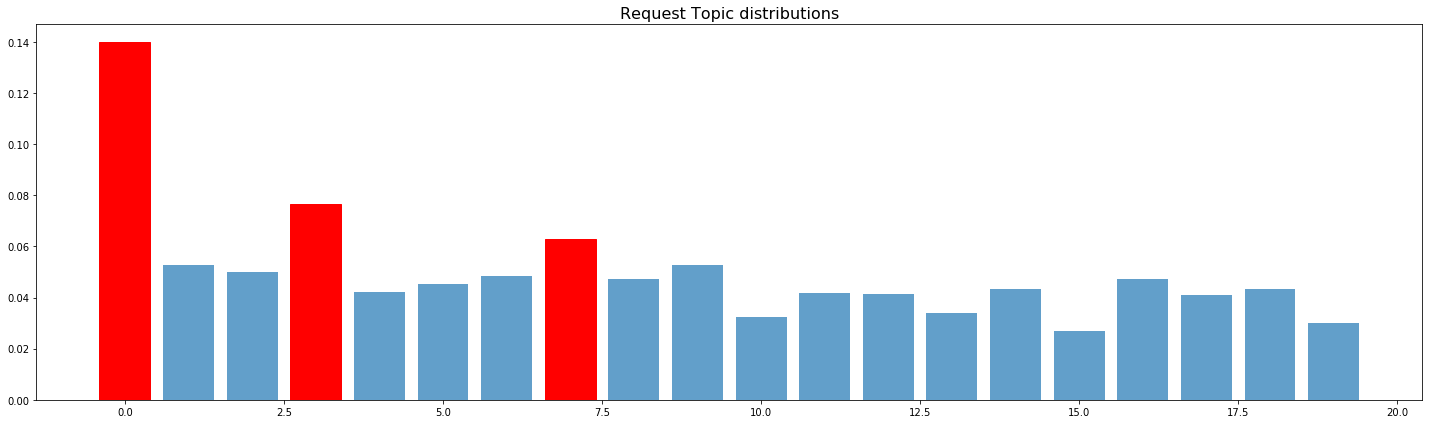

In [41]:
fig, ax1 = plt.subplots(1,1,figsize=(20,6))
nr_top_bars = 3
ax1.set_title("Request Topic distributions", fontsize=16)

for ax, distribution, color in zip([ax1], [RequestTopicDistribution], ['r']):
    # Individual distribution barplots
    ax.bar(range(len(distribution)), distribution, alpha=0.7)
    rects = ax.patches
    for i in np.argsort(distribution)[-nr_top_bars:]:
        rects[i].set_color(color)
        rects[i].set_alpha(1)

fig.tight_layout(h_pad=3.)

#### Inspect topics and words

In [42]:
def get_topic_and_prob(lda_model, topic_id, nr_top_words=7):
    id_tuples = lda_model.print_topic(topic_id, topn=nr_top_words)
    return id_tuples

In [43]:
for x in sorted(np.argsort(RequestTopicDistribution)[-num_topics:]):
    top_words = get_topic_and_prob(LDAmodel_scope, x, 5) #get_topic_top_words(LDAmodel, x)
    print("Topic: {0}\tProb: {1:.3f}, Words: {2}.".format(x, RequestTopicDistribution.item(x), top_words)) #(x, ", ".join(top_words)))
print("")

Topic: 0	Prob: 0.140, Words: 0.051*"vedhæftet" + 0.042*"udfyldt" + 0.031*"frigørelsestilest" + 0.028*"blanket" + 0.028*"dokument".
Topic: 1	Prob: 0.053, Words: 0.081*"efterløn" + 0.073*"barsel" + 0.034*"gå" + 0.027*"går" + 0.020*"barselsdagpeng".
Topic: 2	Prob: 0.050, Words: 0.051*"juni" + 0.043*"løn" + 0.034*"maj" + 0.033*"måned" + 0.026*"novemb".
Topic: 3	Prob: 0.076, Words: 0.133*"dagpeng" + 0.030*"supplerend" + 0.023*"arbejd" + 0.021*"ret" + 0.020*"job".
Topic: 4	Prob: 0.042, Words: 0.068*"dagpeng" + 0.055*"uger" + 0.033*"uge" + 0.023*"mandag" + 0.023*"søgt".
Topic: 5	Prob: 0.045, Words: 0.076*"feri" + 0.073*"dage" + 0.059*"feriepeng" + 0.049*"feriedag" + 0.037*"optjent".
Topic: 6	Prob: 0.048, Words: 0.079*"ansøgn" + 0.049*"befordringsgodtgørels" + 0.040*"forbindels" + 0.037*"virksomhedspraktik" + 0.027*"sktilefri".
Topic: 7	Prob: 0.063, Words: 0.036*"job" + 0.024*"måneder" + 0.016*"arbejd" + 0.016*"gern" + 0.013*"still".
Topic: 8	Prob: 0.047, Words: 0.118*"ledig" + 0.048*"mart" + 

In [44]:
def get_lda_topics(model, num_topics, topn=10):
    word_dict = {};
    for i in sorted(np.argsort(RequestTopicDistribution)[-num_topics:]):
        words = model.show_topic(i, topn = topn);
        word_dict['Topic # ' + '{:02d}'.format(i)] = [i[0] for i in words];
    return pd.DataFrame(word_dict)

In [45]:
get_lda_topics(LDAmodel_scope, num_topics,15)

,Topic # 00,Topic # 01,Topic # 02,Topic # 03,Topic # 04,Topic # 05,Topic # 06,Topic # 07,Topic # 08,Topic # 09,Topic # 10,Topic # 11,Topic # 12,Topic # 13,Topic # 14,Topic # 15,Topic # 16,Topic # 17,Topic # 18,Topic # 19
0,vedhæftet,efterløn,juni,dagpeng,dagpeng,feri,ansøgn,job,ledig,gang,juli,feri,rett,brev,år,septemb,timer,udfyld,kr,udbet
1,udfyldt,barsel,løn,supplerend,uger,dage,befordringsgodtgørels,måneder,mart,sendt,august,feriedagpeng,vedkommend,modtaget,virksomh,uddannels,arbejd,ydelseskort,udbetalt,danmark
2,frigørelsestilest,gå,maj,arbejd,uge,feriepeng,forbindels,arbejd,meldt,forsøgt,måned,optjent,ydelseskort,brevet,selvstændig,august,uge,udfyldt,skat,januar
3,blanket,går,måned,ret,mandag,feriedag,virksomhedspraktik,gern,jobnet,mail,dage,dage,står,ansøgn,tid,sidst,arbejdet,dagpeng,fået,arbejdsgiv
4,dokument,barselsdagpeng,novemb,job,søgt,optjent,sktilefri,still,april,ring,fået,uge,udfyldt,svar,virksomheden,dag,ugen,ledighedserklær,dagpeng,februar
5,sender,termin,decemb,modtag,fået,feriedagpeng,løntilskud,dagpeng,meld,besk,timer,holder,dag,kl,arbejd,oktob,pr,ydelseskortet,udbetalingsspecifik,svar
6,kontrakt,år,arbejdsgiv,period,juli,udbetalt,vedhæftet,forhold,dag,desværr,fejl,udbetalt,tilmeldt,skrev,ansat,juni,haft,perioden,beløb,gdage
7,ansættelseskontrakt,pension,udbetalt,fået,feri,afhold,praktik,søge,blevet,fået,udbetalt,holdt,ydels,læse,haft,su,løn,jul,udbet,besk
8,fremsend,gern,måneder,høre,meldt,hold,præmie,spørgsmål,pr,forkert,dag,søge,udfyld,fået,sidst,studerend,arbejdstim,nytår,modtaget,kontakt
9,blanketten,pr,lønseddel,gern,jobcenteret,maj,blanket,inden,maj,logg,sket,peng,forkert,sendt,opgav,job,timern,indsend,måned,a


#### Name the topics

In [598]:
lda_topic_names = ['Danish','English']# 'Topic_3', 'Topic_4','5','6','7','8','9','10','11','12','13','14','15','16','17','18','19','20']

### Test the model

In [46]:
# unseen_document = 'Hej gitte arensberg. Her er de to skemaer du bad om, hhv. ak 001 og ar 232. Jeg forsøgte at sende skemaerne i mandags, man men fik oplyst på introduktionsmødet tirsdag, at aaks hjemmeside ikke fungerede søndag og mandag. venlig hilsen torben lehm.'
# unseen_document = '''

# Hej Iram,
# Jeg har læst dit materiale igennem.
# Det er rigtig godt, og jeg har ikke fundet stave eller sproglige fejl.
# Det eneste som jeg ville tilføje er et profil afsnit øverst i dit CV, hvor du kort beskriver dine faglige styrker, samt din fortrukne møde at arbejde på.
# Venlig hilsen
# Søren Heilmann
# '''
unseen_document = 'hello,   writing because  would like  know more about the lønsikring (.. how much does  cost extra  month   subscribed? how can  subscribe  ?).  would like  subscribe    soon  possible. thank you very much for your help.'
# unseen_document = 'specialsag - udland - 2nd u13 document - and hopefully the last one'
bow_vector = dictionary.doc2bow(lda_preprocess_string(unseen_document))
for index, score in sorted(LDAmodel_scope[bow_vector], key=lambda tup: -1*tup[1]):
    print("Score: {}\t Topic: {}".format(score, LDAmodel_scope.print_topic(index, 5)))

Score: 0.12456869333982468	 Topic: 0.051*"vedhæftet" + 0.042*"udfyldt" + 0.031*"frigørelsestilest" + 0.028*"blanket" + 0.028*"dokument"
Score: 0.10180450975894928	 Topic: 0.081*"efterløn" + 0.073*"barsel" + 0.034*"gå" + 0.027*"går" + 0.020*"barselsdagpeng"
Score: 0.08607485145330429	 Topic: 0.051*"juni" + 0.043*"løn" + 0.034*"maj" + 0.033*"måned" + 0.026*"novemb"
Score: 0.0745554119348526	 Topic: 0.133*"dagpeng" + 0.030*"supplerend" + 0.023*"arbejd" + 0.021*"ret" + 0.020*"job"
Score: 0.06575533747673035	 Topic: 0.068*"dagpeng" + 0.055*"uger" + 0.033*"uge" + 0.023*"mandag" + 0.023*"søgt"
Score: 0.05881335958838463	 Topic: 0.076*"feri" + 0.073*"dage" + 0.059*"feriepeng" + 0.049*"feriedag" + 0.037*"optjent"
Score: 0.053197186440229416	 Topic: 0.079*"ansøgn" + 0.049*"befordringsgodtgørels" + 0.040*"forbindels" + 0.037*"virksomhedspraktik" + 0.027*"sktilefri"
Score: 0.04856010526418686	 Topic: 0.036*"job" + 0.024*"måneder" + 0.016*"arbejd" + 0.016*"gern" + 0.013*"still"
Score: 0.04466661810

In [47]:
# Test function and prediction
print(PredictTopicFromString(unseen_document, LDAmodel_scope, lda_topic_names))

NameError: name 'PredictTopicFromString' is not defined

### Predict topics on data
Per every row in the dataset

In [400]:
def lda_prediction(df,lda_model, lda_topic_name_list):
    " Make the following function into a function that returns the pred_label and pred_prob below"
#     for index, score in sorted(LDAmodel_lang[bow_vector], key=lambda tup: -1*tup[1]):
#         print("Score: {}\t Topic: {}".format(score, lda_model.print_topic(index, 5)))
    
    df['bow'] = list(map(lambda doc: dictionary.doc2bow(doc), df.stemmed_text))
    df['prediction'] = df['bow'].apply(PredictTopicFromBOW,lda_model=lda_model, lda_topic_name_list=lda_topic_name_list)
    df[['pred_probability','pred_index','pred_label']] = pd.DataFrame(df.prediction.values.tolist(), index= df.index)
    df.drop(['prediction'], axis=1)

In [ ]:
%%time
lda_prediction(df_scope,LDAmodel_scope, lda_topic_names)

#### Save the data with prediction

In [ ]:
df_scope.to_pickle('data/AKA_{0}_with_prediction.pkl'.format(data_scope))

### Load to MS SQL server

In [604]:
%%time
df_raw = pd.read_pickle('data/AKA_rawdata.pkl')

Wall time: 7.98 s


In [105]:
# from lipht_lda import df_lda_preprocessing

In [607]:
%%time
df_lda_preprocessing(df_raw, 'ThreadMessageText')

In [608]:
df_raw.columns

Index(['ThreadID', 'ThreadCreatedFromLetter', 'ThreadTotalMessageCount',
       'ThreadStatus', 'ThreadSubject', 'ThreadResponsibleDepartment',
       'ThreadResponsibleDepartmentTeam', 'ThreadHasInteraction',
       'ThreadInitiatedBy', 'ThreadMessageRank',
       'ThreadMessageIsFirstMemberMessage', 'ThreadMessageIsFirstAKAMessage',
       'ThreadMessageID', 'ThreadMessageDirection', 'ThreadMessageDateCreated',
       'ThreadMessageText', 'text', 'text_CharCount', 'text_LessThan5000',
       'text_WordCount', 'text_Questionmarks', 'text_1Question',
       'text_Exclamationmarks', 'tokenized_text', 'stopwords_removed',
       'lemmatized_text', 'stemmed_text'],
      dtype='object')

In [614]:
df_raw.to_pickle('data/AKA_rawdata_df_lda_preprocessed.pkl')

In [609]:
%%time
lda_prediction(df_raw,LDAmodel_scope, lda_topic_names)

Wall time: 4min 31s


In [626]:
# df_raw[df_raw['pred_label']=='English']['text']

In [611]:
df_raw_with_language = df_raw[['ThreadID','ThreadMessageID','ThreadMessageText','text','pred_label','pred_probability']]

In [612]:
df_raw_with_language.head()

,ThreadID,ThreadMessageID,ThreadMessageText,text,pred_label,pred_probability
0,3F206D77-DFB5-E811-82B4-0050569118B0,46206D77-DFB5-E811-82B4-0050569118B0,"\nDin booking er på plads\n \nVi bekræfter, at...","din booking er på plads\n \nvi bekræfter, at d...",Danish,0.965642
1,A4B4F902-E4B5-E811-82B4-0050569118B0,ABB4F902-E4B5-E811-82B4-0050569118B0,"\n \nDin booking er på plads\nVi bekræfter, at...","din booking er på plads\nvi bekræfter, at du e...",Danish,0.844355
2,C7AAAE22-E4B5-E811-82B4-0050569118B0,CEAAAE22-E4B5-E811-82B4-0050569118B0,"\n \nDin booking er på plads\nVi bekræfter, at...","din booking er på plads\nvi bekræfter, at du e...",Danish,0.866124
3,447AC33F-E6B5-E811-82B4-0050569118B0,4B7AC33F-E6B5-E811-82B4-0050569118B0,\nDu er nu afmeldt ventelisten til LinkedIn\n ...,du er nu afmeldt ventelisten til linkedin\n \n...,Danish,0.966093
4,80A4A5A3-EAB5-E811-82B4-0050569118B0,87A4A5A3-EAB5-E811-82B4-0050569118B0,\nKære Elsa Salvador Rodriguez\n \nDu er nu på...,salvador rodriguez\n \ndu er nu på ventelisten...,Danish,0.946295


In [613]:
df_raw_with_language.to_csv('lang_pred.csv')

In [211]:
con = "mssql+pyodbc:///?odbc_connect={}".format(urllib.parse.quote_plus("DRIVER=ODBC Driver 13 for SQL Server;SERVER={0};PORT=1433;DATABASE={1};UID={2};PWD={3};TDS_Version=8.0;".format(server, db, user, password)))

In [636]:
test = pd.DataFrame({'test':[1,2,3]}) #'te','te','te'

In [ ]:
import pyodbc
from sqlalchemy import create_engine
import urllib

params = urllib.parse.quote_plus(r'DRIVER={SQL Server};SERVER=LIPHT-VM-01;DATABASE=Akademikernes_MSCRM_addition;Trusted_Connection=yes')
conn_str = 'mssql+pyodbc:///?odbc_connect={}'.format(params)
engine = create_engine(conn_str)


test.to_sql(name='Test',con=engine , schema='input', if_exists='replace', index=False)

In [405]:
df_raw.to_pickle('data/AKA_rawdata_with_language.pkl')

In [406]:
df_raw.columns

Index(['ThreadID', 'ThreadCreatedFromLetter', 'ThreadTotalMessageCount',
       'ThreadStatus', 'ThreadSubject', 'ThreadResponsibleDepartment',
       'ThreadResponsibleDepartmentTeam', 'ThreadHasInteraction',
       'ThreadInitiatedBy', 'ThreadMessageRank',
       'ThreadMessageIsFirstMemberMessage', 'ThreadMessageIsFirstAKAMessage',
       'ThreadMessageID', 'ThreadMessageDirection', 'ThreadMessageDateCreated',
       'ThreadMessageText', 'text', 'text_CharCount', 'text_LessThan5000',
       'text_Questionmarks', 'text_1Question', 'text_Exclamationmarks',
       'tokenized_text', 'stopwords_removed', 'lemmatized_text',
       'stemmed_text', 'bow', 'prediction', 'pred_probability', 'pred_index',
       'pred_label'],
      dtype='object')

In [654]:
import ctds
conn = ctds.connect('LIPHT-VM-01', user='ph', password='Partner2018!', database='Akademikernes_MSCRM_addition')
conn.bulk_insert('table', (df_raw_with_language.to_records(index=False).tolist()))

ModuleNotFoundError: No module named 'ctds'